Лабораторна робоа №5, виконав Приймак Євгеній, група КА-13

Тема: Використання технологiї передачi знань для побудови моделi згорткових нейронних
мереж в задачi класифiкацiї кольорових зображень

Мета роботи:
• Навчитися використовувати технологiю передачi знань (transfer learning) для
побудови моделi згорткових нейронних мереж з метою класифiкацiї кольорових
зображень.

• Навчитися створювати моделi згорткових нейронних мереж за допомогою бiблiотеки TensorFlow та API Keras.

• Використати згорткову нейронну мережу для класифiкацiї кольорових зображень.

• Для представлення результатiв використати TensorBoard.

Хід виконання роботи:

1.Завантажити набiр кольорових зображень з попереднього практикуму згiдно з
варiантом. Якщо набiр великого розмiру - можна обрати частину.

2.Пiдготувати данi для навчання. Виконати аугментацiю даних.

3.Роздiлити данi на навчальну, валiдацiйну i тестову пiдмножини.

4.Побудувати моделi класифiкацiї зображень на основi попередньо навчених гли-
боких згорткових мереж, використовуючи технологiю передачi знань (transfer learning):

• Завантажити попередньо навченi ваги. Iмпортувати ваги, отриманi пiд час
навчання обраних глибоких моделей на наборi зображень ImageNet.

• Побудувати один або кiлька верхнiх повнозв’язних шарiв. Останнiм (результуючим)
шаром мережi має бути повнозв’язний softmax-шар з кiлькiстю 
нейронiв, яка дорiвнює кiлькостi класiв в заданому за варiантом наборi
даних.

• Заморозити попередньо навченi ваги. Заморожуючи змiннi попередньої моделi
ми гарантуємо, що буде навчатися тiльки один (кiлька) верхнiх пов-
нозв’язних шарiв; значення попередньої моделi залишаться незмiнними.

• Виконати донавчання доданих верхнiх шарiв на власному наборi зображень.

• Налаштувати параметри доданих верхнiх шарiв на валiдацiйнiй пiдмножинi.

Для дослiдження обрати кiлька попередньо навчених глибоких моделей, наприклад 
з наступних: VGG19, Xception, InceptionV3, ResNet152, DenseNet201, EfficientNetB7.

5.Вiдобразити у TensorBoard графiки, якi iлюструють оцiнки якостi навчання
моделей:
-графiки змiни функцiї втрат на тренувальнiй i валiдацiйнiй множинах по мiрi
навчання моделей,
-графiки змiни показникiв якостi моделi (accuracy, f1-score, AUC) на тренувальнiй
i валiдацiйнiй множинах по мiрi навчання моделей.

6.Розрахувати на тестовiй множинi оцiнки якостi обраної найкращої моделi.

7.Завантажити зображення тестової множини i розпiзнати його навченими моделями.

8.Зробити висновки щодо якостi класифiкацiї на основi побудованих моделей.
Порiвняти з результатами попереднього практикуму.

Варіант 2: Rice Image Dataset, kaggle.com

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from keras import layers
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout, GlobalAveragePooling2D
from keras.models import Sequential,  Model
from tensorflow.keras.applications import resnet50, MobileNet,VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_inputMN
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_inputVG

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split
import random
import pathlib
import os
import struct 
import datetime
import glob
import shutil
from shutil import copyfile

Зменшимо наш набір з 60000 до 10000 фото (виберемо по 2000 рандомних зображень до кожного з 5 класів):

In [3]:
from random import randint

def random_sampling(index, src_dir=None, dst_dir=None):
    for rice_type in os.listdir(src_dir):
        src_rice_dir = os.path.join(src_dir, rice_type)
        dst_rice_dir = os.path.join(dst_dir, rice_type)
        
        if not os.path.exists(dst_rice_dir):
            os.makedirs(dst_rice_dir)

        for i, jpgfile in enumerate(glob.iglob(os.path.join(src_rice_dir, "*.jpg"))):
            if i in index:  
                shutil.copy(jpgfile, dst_rice_dir)

# Index for Random Sampling
index = []
for _ in range(2000):
    value = randint(0, 15000)
    index.append(value)

# Define source dir and destination dir
src_dir = 'E:\\MNIST\\RICE_IMAGES_DATASET'
dst_dir = 'E:\\MNIST\\REDUCED_RICE_DATASET'

random_sampling(index, src_dir=src_dir, dst_dir=dst_dir)

Завантажимо набір RICE_IMAGES_DATASET та виконаємо аугментацію даних для подальшої роботи. Data augmentation створює більш повний і узгоджений набір даних. Застосовано різні техніки аугментації, зокрема методи викривлення даних, такі як: зсув по ширині, зсув по висоті, горизонтальне перевертання, вертикальне перевертання та обертання. Усі ці підходи трансформують дані, зберігаючи при цьому оригінальні значення під ними.

Підготовка генераторів даних для базової однозгорткової моделі CNN:

In [4]:
# loading RICE_IMAGES_DATASET
base_path='E:\\MNIST\\REDUCED_RICE_DATASET'
rice_classes=os.listdir(base_path)
print(rice_classes)

# Training dataset: standardization + data augmentation
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=20,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   shear_range=0.1,
                                   fill_mode='nearest',
                                   validation_split=0.2)

# Validation dataset: standardization
validation_datagen = ImageDataGenerator(rescale=1/255,
                                        validation_split=0.2)

# Training data loader
train_generator = train_datagen.flow_from_directory(base_path,
                                                    target_size=(224, 224),
                                                    color_mode='rgb',
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True,
                                                    seed=1)

# Validation data loader
validation_generator = validation_datagen.flow_from_directory(base_path,
                                                              target_size=(224, 224),
                                                              color_mode='rgb',
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              subset='validation',
                                                              shuffle=False,
                                                              seed=1)

# Виведення розмірів партій зображень та міток для тренувального генератора
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
Found 7520 images belonging to 5 classes.
Found 1880 images belonging to 5 classes.
(32, 224, 224, 3)
(32, 5)


Підготовка генераторів даних для обробки попередньо навченою моделлю ResNet50 (Для подальшого transfer learning): 

In [5]:
#Preprocessing and Splitting into Training and Validation for Best Model with Transfer Learning (preprocessing of the ResNet50 network is added)
size=224
channels=3
batch_size = 64
num_classes = 5

# Training set
train_processing = ImageDataGenerator(preprocessing_function=preprocess_input_resnet50,
                                      validation_split=0.2,
                                      rotation_range = 25,
                                      width_shift_range = .2,
                                      height_shift_range = .2,
                                      horizontal_flip = True,
                                      zoom_range = .2)
# Validation set
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_resnet50,
                                        validation_split=0.2)

# Training data loader 
train_generator_tf = train_processing.flow_from_directory (base_path,   
                                                     target_size=(size, size), 
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     class_mode='categorical',
                                                     subset='training',
                                                     color_mode="rgb",
                                                     interpolation='nearest')

# Validation data loader
validation_generator_tf = validation_datagen.flow_from_directory(base_path,  
                                                              target_size=(size,size),
                                                              subset='validation',
                                                              color_mode="rgb",
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False,
                                                              interpolation='nearest')
for image_batch, labels_batch in train_generator_tf:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Found 7520 images belonging to 5 classes.
Found 1880 images belonging to 5 classes.
(64, 224, 224, 3)
(64, 5)


In [6]:
#Creating Best_model
num_classes = 5

net1 = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Architecture summary
net1.summary()

E:\PyCharm\PyCharm projects\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 112, 112, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │         501,765 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 502,789 (1.92 MB)

 Trainable params: 502,725 (1.92 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/8


E:\PyCharm\PyCharm projects\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 ━━━━━━━━━━━━━━━━━━━━ 170s 707ms/step - accuracy: 0.6491 - loss: 3.7086 - val_accuracy: 0.5479 - val_loss: 1.0205 - learning_rate: 0.0010
Epoch 2/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 113s 474ms/step - accuracy: 0.8378 - loss: 0.4496 - val_accuracy: 0.8250 - val_loss: 0.4979 - learning_rate: 0.0010
Epoch 3/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 112s 466ms/step - accuracy: 0.8559 - loss: 0.3812 - val_accuracy: 0.5606 - val_loss: 1.5742 - learning_rate: 0.0010
Epoch 4/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 110s 459ms/step - accuracy: 0.8888 - loss: 0.3276 - val_accuracy: 0.4213 - val_loss: 4.4241 - learning_rate: 0.0010
Epoch 5/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.8950 - loss: 0.3311
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
235/235 ━━━━━━━━━━━━━━━━━━━━ 112s 468ms/step - accuracy: 0.8950 - loss: 0.3310 - val_accuracy: 0.8452 - val_loss: 0.5132 - learning_rate: 0.0010
Epoch 6/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 113s 470ms/step - accuracy: 0.9235 - loss: 

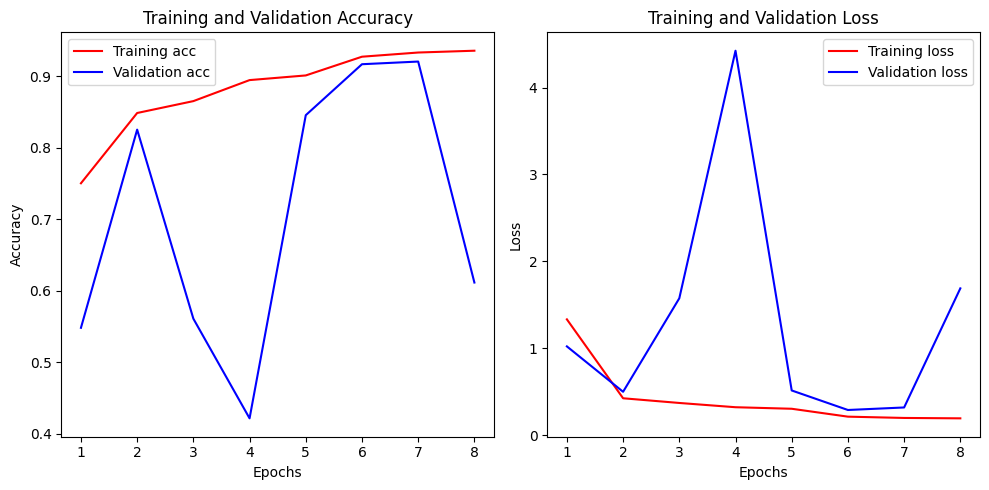

59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step


,precision,recall,f1-score,support
Arborio,0.942623,0.305851,0.461847,376.00000
Basmati,1.000000,0.526596,0.689895,376.00000
Ipsala,1.000000,1.000000,1.000000,376.00000
Jasmine,0.341818,1.000000,0.509485,376.00000
Karacadag,1.000000,0.223404,0.365217,376.00000
accuracy,0.611170,0.611170,0.611170,0.61117
macro avg,0.856888,0.611170,0.605289,1880.00000
weighted avg,0.856888,0.611170,0.605289,1880.00000


In [7]:
# Network Compilation

net1.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
             metrics =['accuracy'])

tensorboard_callback1 = TensorBoard(log_dir='./tf_logs/rice_lab5_modelM2final', histogram_freq=1) #visualization in TensorBoard 

# Reduce Learning Rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                 mode='min',
                                                 patience=3, 
                                                 verbose=1, 
                                                 factor=0.5, 
                                                 min_lr=0.000001)
# Training
history1 = net1.fit(train_generator,
                    epochs = 8,
                    validation_data = validation_generator,
                    callbacks = [tensorboard_callback1, reduce_lr]);

#Model accuracy and loss visalization + metrics
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Y_pred = net1.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
rice_classes=os.listdir(base_path)
report1 = classification_report(validation_generator.classes, y_pred, target_names=rice_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

Реалізація моделі для передачі навчання (обрано ResNet50):

In [8]:
pretrained_model = resnet50.ResNet50(
    weights='imagenet', 
    include_top=False,  
    input_shape=(size, size, 3), 
    pooling='avg',  
)

#freezing the weights that we 'inherited' from the pretraining on imagenet
layer_dict = dict([(layer.name, layer) for layer in pretrained_model.layers])

for layer in pretrained_model.layers:
    layer.trainable = False

#pretrained_model architecture (upper layers)
x2 = pretrained_model.output
x2 = Dense(2048,'relu')(x2)
x2 = Dense(512,'relu')(x2)
x2 = Dropout(.15)(x2)
x2 = Dense(128,'relu')(x2)
x2 = Dense(64,'relu')(x2)
x2 = Dropout(.15)(x2)
x2 = Dense(32,'relu')(x2)
x2 = Dense(16,'relu')(x2)
pred2 = Dense(5,'softmax')(x2)

model2 =  Model(inputs=pretrained_model.input, outputs=pred2)
model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 28,909,765 (110.28 MB)

 Trainable params: 5,322,053 (20.30 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/4


E:\PyCharm\PyCharm projects\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


118/118 ━━━━━━━━━━━━━━━━━━━━ 665s 6s/step - accuracy: 0.4348 - loss: 2.2881 - val_accuracy: 0.9548 - val_loss: 0.1599
Epoch 2/4
118/118 ━━━━━━━━━━━━━━━━━━━━ 650s 5s/step - accuracy: 0.9368 - loss: 0.2101 - val_accuracy: 0.9559 - val_loss: 0.1413
Epoch 3/4
118/118 ━━━━━━━━━━━━━━━━━━━━ 658s 6s/step - accuracy: 0.9573 - loss: 0.1406 - val_accuracy: 0.9819 - val_loss: 0.0747
Epoch 4/4
118/118 ━━━━━━━━━━━━━━━━━━━━ 661s 6s/step - accuracy: 0.9532 - loss: 0.1498 - val_accuracy: 0.9633 - val_loss: 0.1555


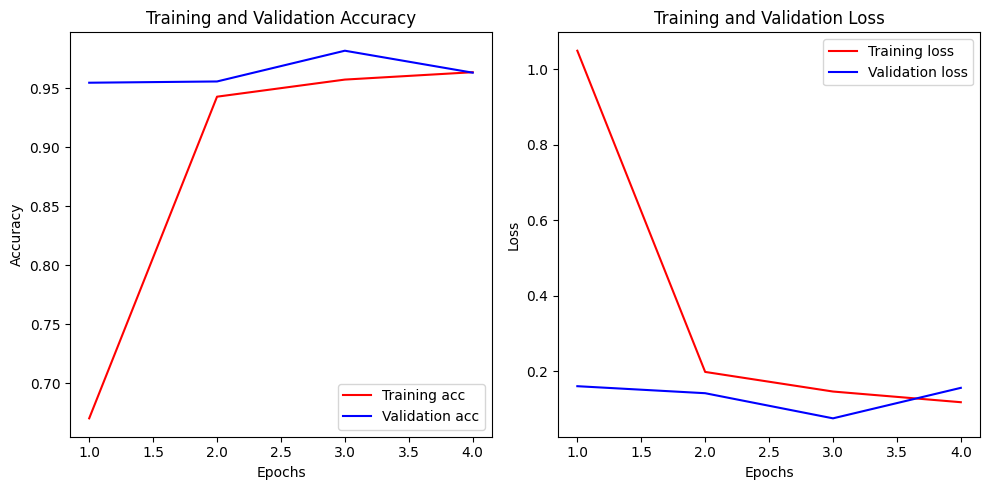

30/30 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step


,precision,recall,f1-score,support
Arborio,0.976127,0.978723,0.977424,376.000000
Basmati,0.994609,0.981383,0.987952,376.000000
Ipsala,0.984252,0.997340,0.990753,376.000000
Jasmine,0.972826,0.952128,0.962366,376.000000
Karacadag,0.981723,1.000000,0.990777,376.000000
accuracy,0.981915,0.981915,0.981915,0.981915
macro avg,0.981908,0.981915,0.981854,1880.000000
weighted avg,0.981908,0.981915,0.981854,1880.000000


In [9]:
model2.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

EarlyStopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

tensorboard_callback2 = TensorBoard(log_dir='./tf_logs/rice_lab5_modelResNet50(final)', histogram_freq=1) #Візуалізація в TensorBoard

history = model2.fit(train_generator_tf,
    epochs=4,  
    validation_data=validation_generator_tf,
    callbacks=[EarlyStopping, tensorboard_callback2])


#Model accuracy and loss visualization + metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Y_pred = model2.predict(validation_generator_tf)
y_pred = np.argmax(Y_pred, axis=1)
rice_classes=os.listdir(base_path)
report1 = classification_report(validation_generator_tf.classes, y_pred, target_names=rice_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

Протестуємо створені моделі класифікацією на тестовому наборі даних:

In [10]:
#Creating test directory and selecting random images (100 per class)
index = []
for _ in range(100):
    value = randint(0, 15000)
    index.append(value)

# Define source dir and destination dir
src_dir = 'E:\\MNIST\\RICE_IMAGES_DATASET'
dst_dir = 'E:\\MNIST\\TEST_RICE_DATASET'

random.seed(123)
random_sampling(index, src_dir=src_dir, dst_dir=dst_dir)

Протестуємо однозгорткову базову модель на тестовому наборі даних: 

In [11]:
test_path='E:\\MNIST\\TEST_RICE_DATASET'
# Validation dataset: standardization

test_datagen1 = ImageDataGenerator(rescale=1/255,
                                  validation_split=0.2)

# Training data loader
test_generator1 = test_datagen1.flow_from_directory(test_path,
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=False,
                                                    seed=1)      

rice_classes = os.listdir(test_path)
print(rice_classes)

Y_pred_test = net1.predict(test_generator1)
y_pred_test = np.argmax(Y_pred_test, axis=1)
report_test  = classification_report(test_generator1.classes, y_pred_test, target_names=rice_classes, output_dict=True)
df1_test = pd.DataFrame(report_test).transpose()
df1_test

Found 500 images belonging to 5 classes.
['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
 1/16 ━━━━━━━━━━━━━━━━━━━━ 5s 361ms/step

E:\PyCharm\PyCharm projects\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step


,precision,recall,f1-score,support
Arborio,1.000000,0.250,0.400000,100.000
Basmati,1.000000,0.400,0.571429,100.000
Ipsala,1.000000,1.000,1.000000,100.000
Jasmine,0.331126,1.000,0.497512,100.000
Karacadag,1.000000,0.330,0.496241,100.000
accuracy,0.596000,0.596,0.596000,0.596
macro avg,0.866225,0.596,0.593036,500.000
weighted avg,0.866225,0.596,0.593036,500.000


Протестуємо модель з передачею навчання (ResNet50) на тестовому наборі:

In [12]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_resnet50)
size=224
channels=3
batch_size = 64
num_classes = 5

test_generator_tf = test_datagen.flow_from_directory(test_path,  
                                                     target_size=(size,size),
                                                     color_mode="rgb",
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=False,
                                                     interpolation='nearest')

Y_pred = model2.predict(test_generator_tf)
y_pred = np.argmax(Y_pred, axis=1)
report2 = classification_report(test_generator_tf.classes, y_pred, target_names=rice_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

Found 500 images belonging to 5 classes.


E:\PyCharm\PyCharm projects\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step


,precision,recall,f1-score,support
Arborio,0.970588,0.990,0.980198,100.000
Basmati,0.988889,0.890,0.936842,100.000
Ipsala,0.980392,1.000,0.990099,100.000
Jasmine,0.895238,0.940,0.917073,100.000
Karacadag,0.990099,1.000,0.995025,100.000
accuracy,0.964000,0.964,0.964000,0.964
macro avg,0.965041,0.964,0.963847,500.000
weighted avg,0.965041,0.964,0.963847,500.000


Результат попереднього практикуму (базова однозгорткова модель для неаугментованого набору Rice_Images_Dataset):

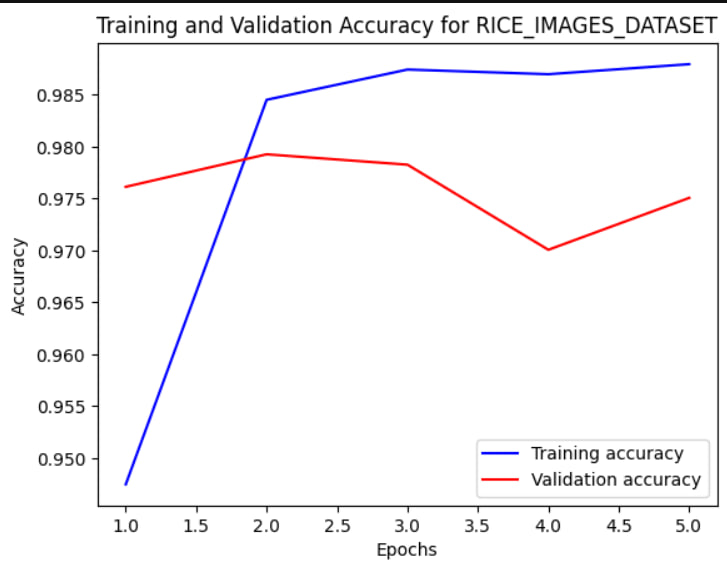

Висновок: зауважимо, модель в якій застосовувалася transfer learning показала себе гірше на тренуванні і набагато краще на валідаційному наборі, що свідчить про допуск більшої кількості помилок задля їх подальшої мінімізації при перевірці. У базових однозгорткових моделях показники тренувань зазвичай були кращими за валідацію. Загалом модель яка попередньо навчена на ImageNet тренується повільніше за рахунок більш комплексної архітектури яка в неї вбудована, але за меншу кількість епох дає набагато кращий результат при опрацюванні складних (наприклад аугментованих) наборів зображень, ніж базова однозгорткова модель CNN.